In [ ]:
pip install --upgrade pip

In [ ]:
pip install -U langgraph langchain_openai

In [ ]:
model_name = "gpt-4o-mini"  #gpt-4o-mini #gpt-3.5-turbo

In [3]:
from typing import List

from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, AIMessage, HumanMessage, ToolMessage


from pydantic import BaseModel, Field

In [4]:
from tempfile import TemporaryDirectory
from langchain_community.agent_toolkits import FileManagementToolkit

file_stores = FileManagementToolkit(
    selected_tools=["read_file", "write_file", "list_directory"], #use current folder
).get_tools()

read_file, write_file, list_file = file_stores

## Define agents to gather information or clarification from user

In [5]:
LAPrompt = """

-- Task -- 
You are a Lead Architect, you are tasked to gather information from user about the HLD they wants to create \
for a software or application. You are expert in consulting and gathering details from user with appropriate examples.

-- Steps must be followed --
1. CRITICAL: Must go through Inputs, ensure you understand 100%.
    a. Extract information from SRS and Check whether you have required information (listed below)
    b. Highlight what you information you need before proceed, what you have it from SRS
    c. Only If you need clarifications, then you must ask questions to user for clarification, only those are not clear
    d. If you have all information (100% sure), then must check the understandings with user and get their confirmation,
    e. Always remind user that if they do not know how to answer, you can help/suggest them with appropriate examples.
2. Do not make assumption unless it is asked by user to help. 
3. IMP: Always, you must verify all your understandings with the user and must seek for confirmation 
4. Repeat steps 1 to 3, till you get all necessary information and understand 100%, then call the relevant tool

-- Inputs -- 
You will receive following **pre-requisites** or **inputs**, 
1. Software Requirement Specification {srs}

-- Required --
- sector: <banking, insurance, telecom, etc.>
- drivers: <why or motivations>
- functionalities: <scope, features, functionalities>
- non-functional requirements> <performance, availability, response time, concurrency, etc>
- channels: <web, mobile, etc> 
- application_type: <B2B, B2C, etc>
- cloud: <Ask user preference, otherwise default with AWS>
- architecture_style: <either monolithic or microservices with or without event-driven architecture, default microservice>
- technology_choice: <Ask user preference, otherwise UI - Streamlit, Backend/API - Python with Flask API, Database - SQLLite
- architecture_decisions:< capture entire ADs and seek confirmation and clarification from user>
- others: <any more inforamtion you need to build solution architecture, be specific, no open questions
"""



def get_messages_info(messages, srs):
    #srs = "SRS:\n" + state['srs'][-1].content
    #srs = state['srs']

    print(srs[-1].content)

    #last_message = "User Query:\n" + state['messages'][-1].content
    
    return[SystemMessage(content=LAPrompt), 
        HumanMessage(content=srs[-1].content)] + messages
    #return[SystemMessage(content=LAPrompt)] + messages

class HighLevelDesign(BaseModel):
    """Instructions on how to prompt the LLM."""
    sector: str # e.g, banking, insurance, telecom, etc.
    drivers: str #motivations
    functionalities: str #scope, features, functionalities
    non_functional_requirement: str
    channels: str 
    application_type: str
    cloud: str #ask user preference
    architecture_style: str #either monolithic or microservices with or without event-driven architecture
    technology_choice: str #backend
    architecture_decisions: str # seek confirmation and clarification
    others: str #anything required to build solution architecture, be specific, no open questions

llm = ChatOpenAI(model=model_name, temperature=0, max_retries=1)
llm_with_tool = llm.bind_tools([HighLevelDesign])

def information_gathering(state):
    messages = get_messages_info(state["messages"], state["srs"])
    hld = state.get('hld')

    if hld:
        pass
    else:
        response = llm_with_tool.invoke(messages)
        return {"messages": [response]}

In [6]:
def conclude_conversation(state):
    return {
        "messages": [
            ToolMessage(
                content="Clarified and proceeding further",
                tool_call_id=state["messages"][-1].tool_calls[0]["id"],
            )
        ]
    }

In [7]:
SAPrompt = '''
-- Role -- 
You are a expert software architect. You need to build a robust architecture

--Task--
As a software architect, you are required to generate software architecture for provided requirements \
and gathered information from user.

-- CRITICAL: Steps MUST be followed --
1. Must go through --Inputs-- 
2. Strictly follow below mentioned --Analysis-- 
2. Create High Level Design Document as mentioned in below --Expected Output--

-- Inputs -- 
You will receive following **pre-requisites** or **inputs**, 
1. Software Requirement Specification
2. Clarifications from user - {reqs}

-- Analysis --
1. Apply --Domain-Driven Design-- Pattern and decompose the requirements
2. Leverage --Design Pattern-- including Microservices Architecture, Event-Driven Architecture Patterns
3. Apply --well-architected framework-- at each and every stage.
3. --Identification-- Based on strategy 1# Identify service.
4. --Communication (Internal)-- Leverage Integration Pattern, and define how each microservice talk or exchange data each other. 
Additionally, For microservice leverage microservice pattern such as circuit breaker, bulk-head, etc.
5. --Expose API(External)-- Leverage API best practices. Define how each microservice  can be accessed from outside.
6. Translate above Analysis Steps 1 to 5 into below mentioned "Expected Output"

-- Expected Output --
{format}
'''

SAReviewPrompt = '''
-- Role -- 
You are a senior software architect. You need to build a robust architecture

--Task--
As a senior software architect, you are required to update HLD to incorporate feedback.

-- CRITICAL: Steps MUST be followed --
1. Must go through --Inputs-- 
2. Strictly follow below mentioned --Analysis-- 
2. Update High Level Design Document to incorporate reviews, follow the below format --Expected Output--

-- Inputs -- 
You will receive following **pre-requisites** or **inputs**, 
1. Software Requirement Specification
2. Review comments from reviewer, {review}

-- Analysis --
1. Understand inputs
2. Update HLD based inputs
3. Must incorporate all review comments
4. Must follow "Expected Output"

-- Expected Output --
{format}

'''


# Function to get the messages for the prompt
# Will only get messages AFTER the tool call
def get_prompt_messages(messages: list, state):
    tool_call = None
    other_msgs = []
    
    for m in messages:
        if isinstance(m, AIMessage) and m.tool_calls:
            tool_call = m.tool_calls[0]["args"]
        elif isinstance(m, ToolMessage):
            continue
        elif tool_call is not None:
            other_msgs.append(m)

    iteration = state['iteration']
    format = state['hld_format'][-1].content
    last_message = state['messages'][-1].content
    srs = state['srs'][-1].content
    
    print("***** Revision Number ****", iteration)
    
    hld = state.get('hld')
    if hld:
        
        hld = state['hld'][-1].content
        
        return[
            SystemMessage(content=SAReviewPrompt.format(review=last_message, format=format)),
            HumanMessage(content=hld + srs)]
    else:
        return[
            SystemMessage(content=SAPrompt.format(reqs=tool_call, format=format)),
            HumanMessage(content=srs) ] + other_msgs 

def generate_hld(state):
    messages = get_prompt_messages(state["messages"], state)
    
    response = llm.invoke(messages)
    iteration = str(state['iteration'])
    file_name = "output/hld v" + str(iteration) +".md"
    
    write_file.invoke({"file_path": file_name, "text": response.content})
    
    return {"messages": [response], 
            "hld": [response]        
    }

In [8]:
critique = """
--Role-- 
Lead Software Architect who is part of Design Authority Review Board. 

--Task--
You are tasked to review the provided design document and share the feedback. 
For that you must the follow below steps.

-- CRITICAL: Steps MUST be followed --
1. Must analyze thoroughly the --Inputs-- 
2. Strictly follow below mentioned --Review-- 

-- Inputs --
1. Software Requirements Specification {srs}
2. High Level Design: {hld} 

--Review--
Check whether HLD aligned with {hld_format}, compliant with architecture & design patterns. \
realize requirements mentioned in requirements. 
Provide all review comments in one attempt.
Be clear, short and concise. Bullet Points.

--Desired Output --
DesignReview = <Say "Satisfied" if there is no review comments, \
Otherwise Say "Enhance" and list of review comments. No obvious feedback. Alignment Scope: <in %> >

"""


#def get_feedback_info(hld, srs):
#    return [SystemMessage(content=critique)] + hld + srs

def get_feedback_info(hld, srs):
    return [SystemMessage(content=critique),
           HumanMessage(content="SRS:\n" + srs[-1].content + "Current HLD:\n" + hld[-1].content)] 

llm = ChatOpenAI(model=model_name, temperature=0, max_retries=1)

def reviewer(state):
    hld = state['hld']
    srs = state['srs']
    messages = get_feedback_info(hld, srs)
    

    response = llm.invoke(messages)

    iteration = str(state['iteration'])
    file_name = "output/hld_feedback v" + str(iteration) +".md"
    
    write_file.invoke({"file_path": file_name, "text": response.content})
    
    max_iteration = state['max_iteration']
    iteration = state['iteration'] + 1
    
    return {
        "messages": [response],
        "iteration": iteration
    }

In [9]:
def is_clarified(state):
    messages = state["messages"]
    hld = state.get('hld')
    if isinstance(messages[-1], AIMessage) and messages[-1].tool_calls:
        return "yes" #"conclude_conversation"
    else:
        return "no" #"continue_conversation"

In [10]:
def is_reviewed(state):
    max_iteration = state['max_iteration']
    iteration = state['iteration']
    last_message = state['messages'][-1].content
   
    if "Satisfied" in last_message.lower():
        return 'reviewed'
    elif iteration > max_iteration:
        return 'reviewed'
    else:
        return 'enhance'

In [11]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import END

class State(TypedDict):
    messages: Annotated[list, add_messages]
    srs: Annotated[list, add_messages]
    hld: Annotated[list, add_messages]
    hld_format: Annotated[list, add_messages]
    max_iteration: int
    iteration: int
    #do_nothing: str
    
    
memory = MemorySaver()
workflow = StateGraph(State)

workflow.add_edge(START, "Seek Clarification")

workflow.add_node("Seek Clarification", information_gathering)
workflow.add_node("Generate HLD", generate_hld)
workflow.add_node("Clarified", conclude_conversation)
workflow.add_node("Review and Feedback",reviewer)

workflow.add_conditional_edges(
    "Seek Clarification", 
    is_clarified, 
    {"yes": "Clarified",  "no": END}
)

workflow.add_conditional_edges(
    "Review and Feedback", 
    is_reviewed, 
    {"reviewed": END,  "enhance": "Generate HLD"}
)

workflow.add_edge("Clarified", "Generate HLD")
workflow.add_edge("Generate HLD", "Review and Feedback")

graph = workflow.compile(checkpointer=memory) #, interrupt_after=['generate_requirements'])

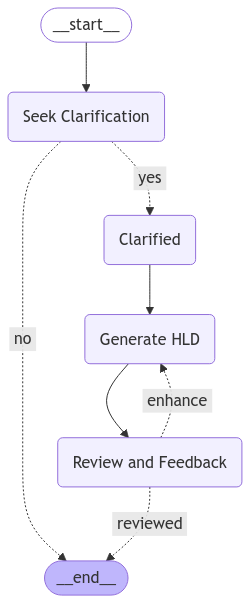

In [12]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
thread = {"configurable": {"thread_id": 9}}
SRS = read_file.invoke({"file_path": "input/srs.md"})
FORMAT = read_file.invoke({"file_path": "input/hld_format.md"})

#print(SRS)

count = 1

while True:
    user = input("User (q/Q to quit): ")
    if user.lower() in ["quit", "q", "Q"]:
        print("AI: Byebye")
        break
    output = None
    

    user_msg = user #+ " \n SRS" + SRS
    #print(count)    
    for output in graph.stream(
        {
            "messages": [HumanMessage(content=user_msg)],
            "srs": [HumanMessage(content=SRS)],
            "hld_format": [HumanMessage(content=FORMAT)],
            "iteration" : 1,
            "max_iteration": 2,
        }, 
        config=thread, 
        stream_mode="updates"):
        #print(output)
        for key, value in output.items():
            print("***** Result from Agent: ",key)
            #print("***** value: ",value)
            
            try:
                last_message = next(iter(output.values()))["messages"][-1]
                last_message.pretty_print()
            except:
                print("pass")

    if output and "generate_hld" in output:
        print("SRS Generated!")
        break

User (q/Q to quit):  generate hld for simple web application


# Updated Software Requirements Specification (SRS) for Task Management System

## 1. Introduction
This Software Requirements Specification (SRS) document outlines the requirements for a web-based task management system designed to enhance operational efficiency, improve performance, and ensure the reliability of task tracking for users. The system will cater to the needs of workers and managers, providing them with tools to manage tasks effectively.

The target audience includes both individual contributors (workers) who need to manage their own tasks and team leaders (managers) who require oversight of team performance and task allocation. The intended impact of this system is to streamline task management processes, reduce time spent on administrative tasks, and improve overall productivity within teams.

### 1.1 Purpose
The purpose of this document is to define the functional and non-functional requirements for the task management system. It aims to provide a clear understanding of

User (q/Q to quit):  yes, 1. it is to track productivity of resources, 2. no, 3. aws, 4. streamlit, fastapi, python, 5. no


# Updated Software Requirements Specification (SRS) for Task Management System

## 1. Introduction
This Software Requirements Specification (SRS) document outlines the requirements for a web-based task management system designed to enhance operational efficiency, improve performance, and ensure the reliability of task tracking for users. The system will cater to the needs of workers and managers, providing them with tools to manage tasks effectively.

The target audience includes both individual contributors (workers) who need to manage their own tasks and team leaders (managers) who require oversight of team performance and task allocation. The intended impact of this system is to streamline task management processes, reduce time spent on administrative tasks, and improve overall productivity within teams.

### 1.1 Purpose
The purpose of this document is to define the functional and non-functional requirements for the task management system. It aims to provide a clear understanding of

User (q/Q to quit):  Elaborate each sections with suitable examples


# Updated Software Requirements Specification (SRS) for Task Management System

## 1. Introduction
This Software Requirements Specification (SRS) document outlines the requirements for a web-based task management system designed to enhance operational efficiency, improve performance, and ensure the reliability of task tracking for users. The system will cater to the needs of workers and managers, providing them with tools to manage tasks effectively.

The target audience includes both individual contributors (workers) who need to manage their own tasks and team leaders (managers) who require oversight of team performance and task allocation. The intended impact of this system is to streamline task management processes, reduce time spent on administrative tasks, and improve overall productivity within teams.

### 1.1 Purpose
The purpose of this document is to define the functional and non-functional requirements for the task management system. It aims to provide a clear understanding of

User (q/Q to quit):  approved


# Updated Software Requirements Specification (SRS) for Task Management System

## 1. Introduction
This Software Requirements Specification (SRS) document outlines the requirements for a web-based task management system designed to enhance operational efficiency, improve performance, and ensure the reliability of task tracking for users. The system will cater to the needs of workers and managers, providing them with tools to manage tasks effectively.

The target audience includes both individual contributors (workers) who need to manage their own tasks and team leaders (managers) who require oversight of team performance and task allocation. The intended impact of this system is to streamline task management processes, reduce time spent on administrative tasks, and improve overall productivity within teams.

### 1.1 Purpose
The purpose of this document is to define the functional and non-functional requirements for the task management system. It aims to provide a clear understanding of